In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import cv2
from PIL import Image, ImageFont, ImageDraw
import pandas as pd

import torch
import easyocr

mpl.rcParams['image.cmap'] = 'gray'
torch.cuda.is_available()


True

In [2]:
A4img = cv2.imread("a4_med_sharp.png", cv2.IMREAD_GRAYSCALE)

reader = easyocr.Reader(lang_list=['en'], gpu=True)
# results = reader.readtext(A4img, width_ths=0.2)  # 84.9%
results = reader.readtext(A4img, width_ths=0.2)


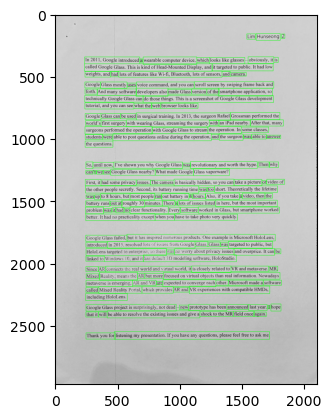

In [3]:
A4img_show = cv2.cvtColor(A4img.copy(), cv2.COLOR_GRAY2RGB)

for (bbox, text, prob) in results:
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))
    cv2.rectangle(A4img_show, tl, br, (0, 255, 0), 2)

plt.imshow(A4img_show)


In [4]:
def normalize(array: np.ndarray, inplace: bool = False) -> np.ndarray:
    if not inplace:
        array = array.copy()
    cv2.normalize(array, array, 0, 255, cv2.NORM_MINMAX)
    thres, _ = cv2.threshold(array, -1, maxval=255, type=cv2.THRESH_OTSU)
    array[array > thres] = 255
    return array


def trunc_white(array: np.ndarray) -> np.ndarray:
    row, col = array.shape
    row_start, row_end = 0, row-1
    col_start, col_end = 0, col-1

    while row_start < row:
        if array[row_start].min() != 255:
            break
        row_start += 1
    while row_end >= 0:
        if array[row_end].min() != 255:
            break
        row_end -= 1
    while col_start < col:
        if array[:, col_start].min() != 255:
            break
        col_start += 1
    while col_end >= 0:
        if array[:, col_end].min() != 255:
            break
        col_end -= 1

    array = array[row_start:row_end+1, col_start:col_end+1]
    return array


def sixteen_padding(array: np.ndarray) -> np.ndarray:
    x = array.shape[1]
    y = array.shape[0]
    x_pad = (x // 16 + 1) * 16 - x
    y_pad = (y // 16 + 1) * 16 - y
    array = np.pad(array, ((y_pad//2, y_pad//2 + y_pad%2),(x_pad//2, x_pad//2 + x_pad%2)), 'constant', constant_values=255)
    return array


In [5]:
scale = 10
font_paths = {
    "Arial": "fonts/arial.ttf",
    "Comic Sans MS": "fonts/comic.ttf",
    "Courier New": "fonts/cour.ttf",
    "Malgun Gothic": "fonts/malgun.ttf",
    "Times New Roman": "fonts/times.ttf",
}
fonts = {
    k: ImageFont.truetype(v, 50)
    for k, v
    in font_paths.items()
}


In [6]:
def get_descriptor(array: np.ndarray) -> cv2.HOGDescriptor:
    win_size = array.shape[::-1]
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    return cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)


In [7]:
distance_dict: dict[str, list[np.ndarray]] = {k: [] for k in font_paths.keys()}

for (bbox, text, prob) in results:
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    tr = (int(tr[0]), int(tr[1]))
    br = (int(br[0]), int(br[1]))
    bl = (int(bl[0]), int(bl[1]))

    image_text = normalize(A4img[tl[1]:bl[1], tl[0]:tr[0]], inplace=False)
    image_text = trunc_white(image_text)
    image_text = sixteen_padding(image_text)

    descriptor = get_descriptor(image_text)
    image_hog: np.ndarray = descriptor.compute(image_text)

    for font_name, font in fonts.items():
        canvas = Image.new('L', size=(3000, 80), color='white')
        draw = ImageDraw.Draw(canvas)
        draw.text((0, 0), text, 'black', font=font)
        rendered_text = np.array(canvas)
        rendered_text = trunc_white(rendered_text)
        rendered_text = sixteen_padding(rendered_text)
        rendered_text = cv2.resize(rendered_text, image_text.shape[::-1], interpolation=cv2.INTER_CUBIC)

        text_hog: np.ndarray = descriptor.compute(rendered_text)
        dist = distance.euclidean(image_hog, text_hog)  # Euclidean
        # dist = distance.cityblock(image_hog, text_hog)  # 1-norm
        # dist = distance.chebyshev(image_hog, text_hog)  # inf-norm  # Dangerous!
        distance_dict[font_name].append(dist)

distance_table = pd.DataFrame(distance_dict)
distance_table


,Arial,Comic Sans MS,Courier New,Malgun Gothic,Times New Roman
0,3.611133,4.088589,4.219999,3.369078,3.925570
1,5.440527,6.278767,5.641813,4.125534,6.612174
2,2.091361,2.061244,1.628918,1.833088,1.846458
3,13.576964,15.088812,14.028829,14.170430,12.950743
4,0.929337,1.102986,0.836363,0.963950,0.904971
...,...,...,...,...,...
167,24.085732,24.776491,22.602993,23.599741,20.478827
168,3.373893,3.624312,3.343840,3.338679,2.731909
169,3.340357,3.902729,3.798541,4.188799,2.702780
170,4.163782,3.470093,3.170622,3.582742,3.453589


In [8]:
most_close_fonts = distance_table.idxmin(axis='columns')
most_close_fonts.value_counts()
# most_close_fonts.value_counts()["Times New Roman"] / most_close_fonts.count() * 100


Times New Roman    144
Malgun Gothic       13
Courier New          7
Comic Sans MS        4
Arial                4
Name: count, dtype: int64

In [ ]:
each_fonts = most_close_fonts.to_list()
